In [3]:
!pip install hana_ml
!pip install tbats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.1 MB 8.6 MB/s 
     |████████████████████████████████| 11.6 MB 30.2 MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=dfb3436cc3428a6082779ec319a31ee7c12c910b3de827d8caee83481be468b5
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
Successfully built htmlmin
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 


In [1]:
!pip install statsmodels
!pip install arch
!pip install sktime
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 7.8 MB/s 
     |████████████████████████████████| 9.8 MB 34.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.8 MB 7.4 MB/s 
     |████████████████████████████████| 3.3 MB 43.0 MB/s 
     |████████████████████████████████| 34.5 MB 15 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
  

# Loading Library

In [4]:
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas.util.testing as tm
from statsmodels.tsa.stattools import adfuller
from hana_ml.algorithms.pal.tsa.vector_arima import VectorARIMA


# Loading Documents

Description:
*   The data is composed of 5 different datasets related to grape syrup: Daily 
precipitation, daily soil moisture, daily temperature, eight day NDVI, and production quantity. 
*   The time series analysis is intent to predict the future grape syrup production for 2021-2022.

*   All datasets are penel data composed of timestamp, corresponding value and region number. Region number denotes the group variable in panel data. 

In [5]:
#setting initial variable for data by loading documents
Precipitation_series = read_csv('Daily Precipitation.csv', index_col=0,usecols=[0,2,3])
Moistrue_series = read_csv('Daily Soil Mositure.csv', index_col=0,usecols=[0,2,3])
Temperature_series = read_csv('Daily Temperature.csv', index_col=0,usecols=[0,2,3])
NDVI_series = read_csv('Eight Day NDVI.csv', index_col=0,usecols=[0,2,3])
Production_series = read_csv('Production Quantity.csv', index_col=0,usecols=[0,2,3])
predicted_production_series = read_csv('predicted_production_qty.csv', index_col=0,usecols=[0,2,3])
dataset_list=[Precipitation_series,Moistrue_series,Temperature_series,NDVI_series,Production_series]
name_list=["precip","smos","temp","ndvi","prod"]

print(Precipitation_series.keys())

Index(['precip', 'region_id'], dtype='object')


## Visualize the data distribution for each region for each dataset and check if stationary

We can see that the only unstationary dataset is the daily precipitation dataset

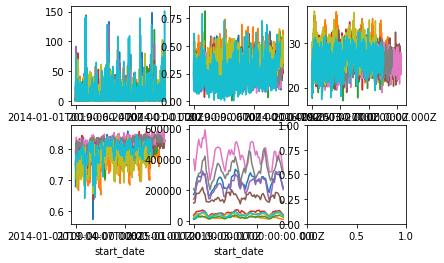

In [ ]:
fig, axes = plt.subplots(2, 3) 
Precipitation_series.groupby('region_id').plot(ax=axes[0,0],y=["precip"],legend=False)
Moistrue_series.groupby('region_id').plot(ax=axes[0,1],y=["smos"],legend=False)
Temperature_series.groupby('region_id').plot(ax=axes[0,2],y=["temp"],legend=False)
NDVI_series.groupby('region_id').plot(ax=axes[1,0],y=["ndvi"],legend=False)
Production_series.groupby('region_id').plot(ax=axes[1,1],y=["prod"],legend=False)
#predicted_production_series.groupby('region_id').plot(ax=axes[1,2],y=["prod"],legend=False)
pyplot.show()

In [ ]:
Precipitation_series['precip']
#normalize Daily Precipitation data
Precipitation_series['precip']=np.log(Precipitation_series['precip'])

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Production Data Only for Prediction

**The following part is univariate future production prediction based on past production**

## Convert to Datetime Form

In [ ]:
#normalize Daily Precipitation data and perform aggregation based on month
temp=Precipitation_series.groupby('region_id').get_group(93)
U=temp.filter(like='2014-01',axis=0)#.plot(y=["precip"],legend=False)
for idx in range(0,len(dataset_list)):
  dataset_list[idx]=dataset_list[idx].assign(start_Date=dataset_list[idx].index)#.assign(Date=lambda x:x['Date'].astype(str))
  dataset_list[idx]['start_Date']=pd.to_datetime(dataset_list[idx]['start_Date'], format='%Y-%m-%dT%H:%M:%S.%fZ')#.assign(Date=lambda x:datetime.datetime.strptime(x['Date'],"%Y-%m-%dT%H:%M:%S.%fZ"))#.resample('M',on='Date').precip.sum().last().set_index('Date')
  dataset_list[idx]['start_Date']=dataset_list[idx]['start_Date'].dt.to_period('M')
  dataset_list[idx]=dataset_list[idx].set_index('start_Date')
  # temp=temp.assign(start_Date=temp.index)#.assign(Date=lambda x:x['Date'].astype(str))
  # temp['start_Date']=pd.to_datetime(temp['start_Date'], format='%Y-%m-%dT%H:%M:%S.%fZ')#.assign(Date=lambda x:datetime.datetime.strptime(x['Date'],"%Y-%m-%dT%H:%M:%S.%fZ"))#.resample('M',on='Date').precip.sum().last().set_index('Date')
  # dataset_list[idx]=temp.set_index('start_Date')
print(dataset_list[0])

               precip  region_id
start_Date                      
2014-01      1.392393         93
2014-01      0.315380         93
2014-01      2.347846         93
2014-01     21.466357         93
2014-01     32.823651         93
...               ...        ...
2022-03      0.041747        105
2022-03      0.090011        105
2022-03      0.021150        105
2022-03      0.092205        105
2022-03      2.719724        105

[29940 rows x 2 columns]


**Extract different region to different groups**

In [ ]:
#get group info, 3rd element shows how many group there are, third line gets all keys in the group object
GrouperObj=Precipitation_series.groupby('region_id')
df=GrouperObj.grouper.group_info
keys=[key for key, _ in GrouperObj]
a=0

#seperate all regions into diff element in list, each element combines all data for specific time frame
big_df_list=[]
for g_i in df[1]:
  big_df=dataset_list[4].groupby('region_id').get_group(keys[g_i])
  a=big_df
  #big_df['prod']=np.log(big_df['prod'])
  big_df_list.append(big_df)
for i in range(len(big_df_list)):
  print(big_df_list[i])

              prod  region_id
start_Date                   
2015-01     171725         93
2015-02     188325         93
2015-03     247856         93
2015-04     282791         93
2015-05     291057         93
...            ...        ...
2020-08     301528         93
2020-09     302692         93
2020-10     273522         93
2020-11     246388         93
2020-12     217480         93

[72 rows x 2 columns]
             prod  region_id
start_Date                  
2015-01     15066         94
2015-02     20527         94
2015-03     31839         94
2015-04     33341         94
2015-05     35627         94
...           ...        ...
2020-08     17199         94
2020-09     16695         94
2020-10     13235         94
2020-11     10215         94
2020-12     10714         94

[72 rows x 2 columns]
             prod  region_id
start_Date                  
2015-01     11181         95
2015-02     11847         95
2015-03     18858         95
2015-04     26044         95
2015-05     2

## Import models

In [ ]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.naive import NaiveForecaster
import lightgbm as lgb
from sktime.performance_metrics.forecasting import     mean_absolute_percentage_error
import numpy as np



## Train test split

In [ ]:
def add_freq(idx, freq=None):
    """Add a frequency attribute to idx, through inference or directly.

    Returns a copy.  If `freq` is None, it is inferred.
    """

    idx = idx.copy()
    if freq is None:
        if idx.freq is None:
            freq = pd.infer_freq(idx)
            print("hey")
        else:
            return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq)
    if idx.freq is None:
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx

#train test split
test_size = 12
data_train_list=[]
data_test_list=[]
i=0
for g_i in df[1]:
  #big_df_list[g_i].rename(columns=({'prod':'`freq`'}),inplace=True)
  #print(big_df_list[g_i].head())
  big_df_list[g_i].asfreq('M')
  data_train_list.append(big_df_list[g_i]['prod'][:-test_size])
  data_test_list.append(big_df_list[g_i]['prod'][-test_size:])
  print(data_train_list[i].index)
  i+=1
#data_train_list[0].asfreq('d')
y_train=data_train_list[0]
y_test=data_test_list[0]
fh = np.arange(len(y_test)) + 1
print(data_train_list[0].index)

PeriodIndex(['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
             '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
             '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
             '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
             '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
             '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
             '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
             '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
             '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
             '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12'],
            dtype='period[M]', name='start_Date')
PeriodIndex(['2015-01', '2015-02', '2015-03', '2015-04', '2015-05', '2015-06',
             '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
 

## Naive Forecaster

/usr/local/lib/python3.7/dist-packages/sktime/performance_metrics/forecasting/_functions.py:1548: FutureWarning: In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
  FutureWarning,


0.11821562101807444


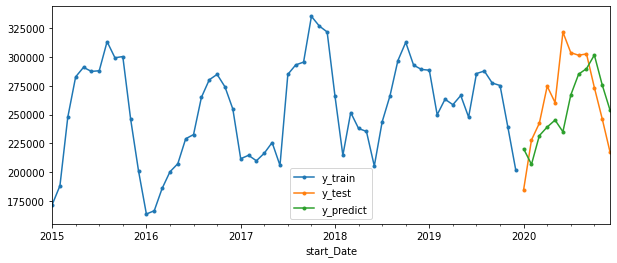

In [ ]:
forecaster = NaiveForecaster(strategy="mean", sp=12)
forecaster.fit(data_train_list[0])
y_pred = forecaster.predict(fh)
print(mean_absolute_percentage_error(y_pred, data_test_list[0]))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
y_train.plot(ax=ax, label='y_train', style='.-')
y_test.plot(ax=ax, label='y_test', style='.-')
y_pred.plot(ax=ax, label='y_predict', style='.-')
plt.legend()
plt.show()
#plt.savefig('predict-airline-data-plot.png', dpi=300, bbox_inches='tight')
#plt.close('all')

## KNN Regressor

/usr/local/lib/python3.7/dist-packages/sktime/performance_metrics/forecasting/_functions.py:1548: FutureWarning: In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
  FutureWarning,


0.09858862153333531


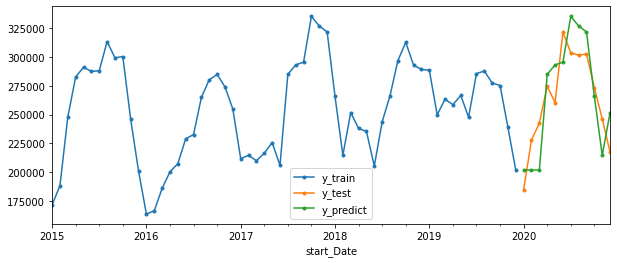

In [ ]:
from sktime.forecasting.compose import make_reduction
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
#forecaster = AutoARIMA(start_p=2, max_p=9, suppress_warnings=True,m=12)
forecaster = make_reduction(
   regressor, scitype="infer", window_length=15, strategy="recursive"
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
print(mean_absolute_percentage_error(y_test, y_pred))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
y_train.plot(ax=ax, label='y_train', style='.-')
y_test.plot(ax=ax, label='y_test', style='.-')
y_pred.plot(ax=ax, label='y_predict', style='.-')
plt.legend()
plt.show()
# plt.savefig('predict-KNeighborsRegressor-airline-data-plot.png',
#             dpi=300, bbox_inches='tight')
# plt.close('all')


## Statistical Forecaster

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sktime/performance_metrics/forecasting/_functions.py:1548: FutureWarning: In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
  FutureWarning,


0.3203281540265593


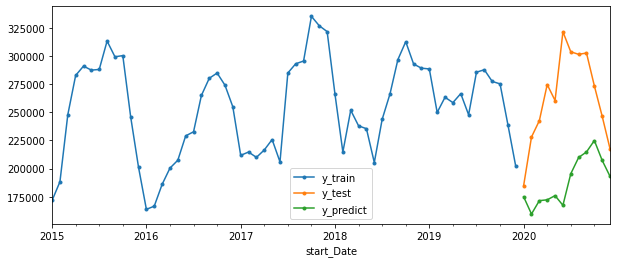

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing(trend="mul",damped_trend=True, seasonal="mul", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
print(mean_absolute_percentage_error(y_test, y_pred))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
y_train.plot(ax=ax, label='y_train', style='.-')
y_test.plot(ax=ax, label='y_test', style='.-')
y_pred.plot(ax=ax, label='y_predict', style='.-')
plt.legend()
plt.show()

## AutoARIMA

0.07617780607041068


/usr/local/lib/python3.7/dist-packages/sktime/performance_metrics/forecasting/_functions.py:1548: FutureWarning: In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
  FutureWarning,


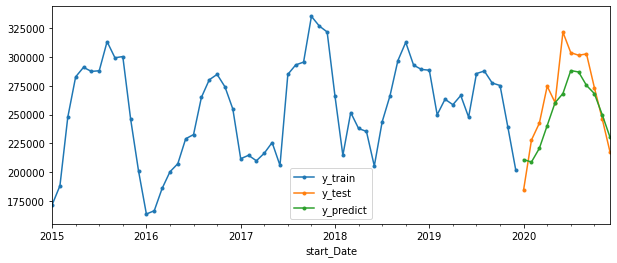

In [ ]:
#model fit and predict
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
print(mean_absolute_percentage_error(y_test, y_pred))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
y_train.plot(ax=ax, label='y_train', style='.-')
y_test.plot(ax=ax, label='y_test', style='.-')
y_pred.plot(ax=ax, label='y_predict', style='.-')
plt.legend()


## tbats

0.1990064494382241


/usr/local/lib/python3.7/dist-packages/sktime/performance_metrics/forecasting/_functions.py:1548: FutureWarning: In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
  FutureWarning,


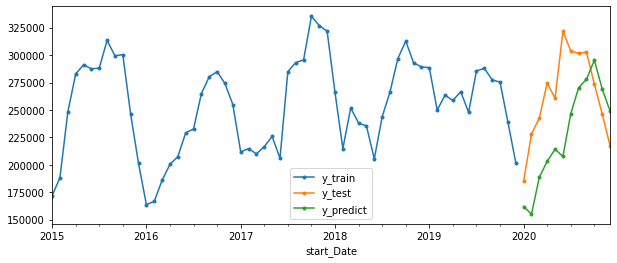

In [ ]:
from sktime.forecasting.tbats import TBATS
forecaster = TBATS(use_box_cox=True,use_trend=True,use_damped_trend=True,sp=12,use_arma_errors=True,n_jobs=1)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
print(mean_absolute_percentage_error(y_test, y_pred))

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
y_train.plot(ax=ax, label='y_train', style='.-')
y_test.plot(ax=ax, label='y_test', style='.-')
y_pred.plot(ax=ax, label='y_predict', style='.-')
plt.legend()

# All Data Prediction based on Monthly Aggregation


The followings are multivariate prediction based on 5 datasets

In [6]:
temp=Precipitation_series.groupby('region_id').get_group(93)
U=temp.filter(like='2014-01',axis=0)#.plot(y=["precip"],legend=False)
for idx in range(0,len(dataset_list)):
  dataset_list[idx]=dataset_list[idx].assign(start_Date=dataset_list[idx].index)#.assign(Date=lambda x:x['Date'].astype(str))
  dataset_list[idx]['start_Date']=pd.to_datetime(dataset_list[idx]['start_Date'], format='%Y-%m-%dT%H:%M:%S.%fZ')#.assign(Date=lambda x:datetime.datetime.strptime(x['Date'],"%Y-%m-%dT%H:%M:%S.%fZ"))#.resample('M',on='Date').precip.sum().last().set_index('Date')
  #dataset_list[idx]['start_Date']=dataset_list[idx]['start_Date'].dt.to_period('M')
  dataset_list[idx]=dataset_list[idx].set_index('start_Date')
print(dataset_list[0])

               precip  region_id
start_Date                      
2014-01-01   1.392393         93
2014-01-02   0.315380         93
2014-01-03   2.347846         93
2014-01-04  21.466357         93
2014-01-05  32.823651         93
...               ...        ...
2022-03-09   0.041747        105
2022-03-10   0.090011        105
2022-03-11   0.021150        105
2022-03-12   0.092205        105
2022-03-13   2.719724        105

[29940 rows x 2 columns]


In [7]:
#get group info, 3rd element shows how many group there are, third line gets all keys in the group object
GrouperObj=Precipitation_series.groupby('region_id')
df=GrouperObj.grouper.group_info
keys=[key for key, _ in GrouperObj]
a=0

#seperate all regions into diff element in list, each element combines all data for specific time frame
big_df_list=[]
for g_i in df[1]:
  big_df=dataset_list[0].groupby('region_id').get_group(keys[g_i]).resample('M').agg({name_list[0]:'sum','region_id':'first'})#.sum()
  a=big_df
  big_df['precip']=np.log(big_df['precip'])
  for idx in range(1,len(dataset_list)):
    temp=dataset_list[idx].groupby('region_id').get_group(keys[g_i])
    temp=temp.resample('M').agg({name_list[idx]:'sum','region_id':'first'})#[name_list[idx]].sum()
    big_df=big_df.merge(temp[name_list[idx]],how='inner', left_index=True, right_index=True)#,on=big_df.index)#'start_Date')
    #print(dataset_list[idx])
  big_df=big_df.drop(['region_id'], axis=1)

  #print(big_df.index)
  big_df=big_df.to_period('M')
  big_df_list.append(big_df)
for i in range(len(big_df_list)):
  print(big_df_list[i])

              precip       smos        temp      ndvi    prod
start_Date                                                   
2015-01     4.914330   9.875098  375.053896  3.044914  171725
2015-02     3.519628   8.160648  455.728664  3.035830  188325
2015-03     4.673709   7.559063  377.357524  3.011018  247856
2015-04     5.749374   7.467456  350.335245  1.570114  282791
2015-05     5.632099   8.698660  406.481930  3.221048  291057
...              ...        ...         ...       ...     ...
2020-08     4.842853  11.816457  247.264486  3.255471  301528
2020-09     5.359483  10.724566  194.255859  3.262683  302692
2020-10     4.837260  10.051515  255.623806  1.627275  273522
2020-11     5.558532  12.328311   55.971207  1.609072  246388
2020-12     5.269922  12.956250  124.303763  1.626919  217480

[72 rows x 5 columns]
              precip       smos        temp      ndvi   prod
start_Date                                                  
2015-01     3.801614   7.793860  584.303098  3.07

In [ ]:
#check if stationary
def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")
for g_i in range(0,len(dataset_list)):
  adfuller_test(big_df_list[0][name_list[g_i]], name=name_list[g_i])

 precip : P-Value = 0.038 => Stationary. 
 smos : P-Value = 0.008 => Stationary. 
 temp : P-Value = 0.0 => Stationary. 
 ndvi : P-Value = 0.0 => Stationary. 
 prod : P-Value = 0.0 => Stationary. 


**Train Test Split**

In [13]:
from sktime.forecasting.model_selection import temporal_train_test_split

test_size = 12
data_train_list=[]
data_test_list=[]
data_train_list_x=[]
data_train_list_y=[]
data_test_list_x=[]
data_test_list_y=[]
for g_i in df[1]:
  y = big_df_list[g_i]['prod']
  X = big_df_list[g_i].drop(['prod'], axis=1) #could be more features
  y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=12)
  data_train_list_x.append(X_train)
  data_train_list_y.append(y_train)
  data_test_list_x.append(X_test)
  data_test_list_y.append(y_test)
  # data_train_list.append(big_df_list[g_i][:-test_size])
  # data_test_list.append(big_df_list[g_i]['prod'][-test_size:])

# vectorArima1 = VectorARIMA(order=(-1, 2, -1), model_type = 'VARMA', search_method='grid_search', output_fitted=True, max_p=5, max_q=5)
# vectorArima1.fit(data=data_train_list[0])
print(data_test_list_y[0])
print()

start_Date
2020-01    184890
2020-02    228046
2020-03    242595
2020-04    274686
2020-05    260507
2020-06    321550
2020-07    303763
2020-08    301528
2020-09    302692
2020-10    273522
2020-11    246388
2020-12    217480
Freq: M, Name: prod, dtype: int64



## AutoARIMA

MAPE score is:  0.08699604303016371
MAPE score is:  0.4228881130135849
MAPE score is:  0.07799870810636517
MAPE score is:  0.21150863205925932
MAPE score is:  0.13289844241772245
MAPE score is:  0.12821785690238438
MAPE score is:  0.1108664285394221
MAPE score is:  0.07475403174045676
MAPE score is:  0.11359135586273199


MAPE score is:  0.08279377216923352


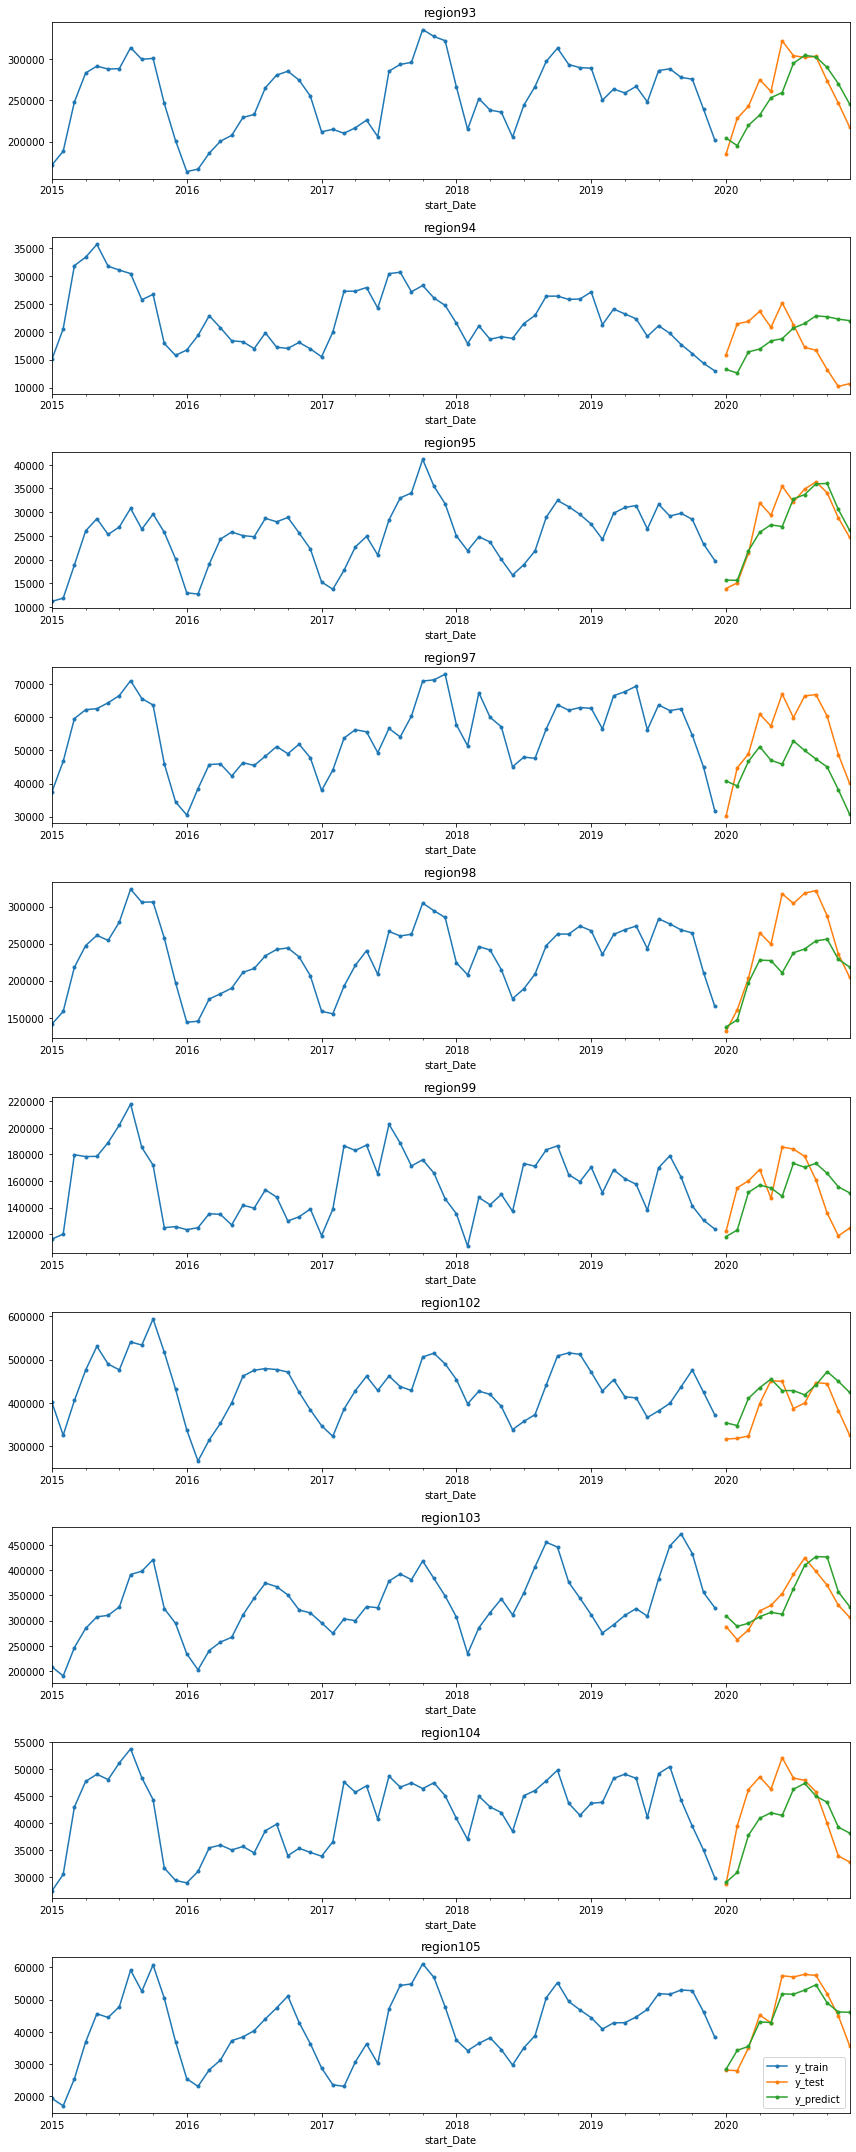

In [17]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import     mean_absolute_percentage_error

forecasters=[]
y_predicts=[]
for i in range(len(df[1])):
  fh_abs = ForecastingHorizon(data_test_list_y[i].index, is_relative=False) 
  forecaster = AutoARIMA(sp=12, suppress_warnings=True,method='powell')
  forecaster.fit(data_train_list_y[i],data_train_list_x[i])
  forecaster.summary()
  forecasters.append(forecaster)
  y_pred = forecaster.predict(X=data_test_list_x[i], fh=fh_abs)
  y_predicts.append(y_pred)
  print("MAPE score is: ",mean_absolute_percentage_error(data_test_list_y[i], y_pred))


fig, ax = plt.subplots(len(df[1]),figsize=(12,30))

def plot_predict(data_train_list_y,data_test_list_y,model,ax,region,y_pred):
  data_train_list_y.plot(ax=ax, label='y_train', style='.-')
  data_test_list_y.plot(ax=ax, label='y_test', style='.-')
  y_pred.plot(ax=ax, label='y_predict', style='.-')
  plt.legend()
  ax.set_title('region'+str(region))
for g_i in range(len(df[1])): 
  plot_predict(data_train_list_y[g_i],data_test_list_y[g_i],forecasters[g_i],ax[g_i],keys[g_i],y_predicts[g_i])
fig.tight_layout()

## LSTM

In [ ]:
import torch
from torch import nn
from torch import optim
from model import LSTM

In [ ]:
k=torch.tensor([[1,2,3],[1,2,3]])
print(k.view(-1,1).size())
for kk in k.split(1,dim=1):
  print(kk)
#print(k[1,:])
t=[1,2,3]
t.extend([2,3])
t

torch.Size([6, 1])
tensor([[1],
        [1]])
tensor([[2],
        [2]])
tensor([[3],
        [3]])


[1, 2, 3, 2, 3]

In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
sc_y=StandardScaler()
for g_i in range(len(df[1])):
  data_train_list_x[g_i]=sc.fit_transform(data_train_list_x[g_i])
  data_train_list_y[g_i]=sc_y.fit_transform(data_train_list_y[g_i].to_numpy().reshape((-1,1)))
  #print(data_train_list_x[g_i])
  data_test_list_x[g_i]=sc.transform(data_test_list_x[g_i])
  data_test_list_y[g_i]=sc_y.fit_transform(data_test_list_y[g_i].to_numpy().reshape((-1,1)))
  #print(g_i,data_train_list_x[g_i].size(),data_train_list_y[g_i].size(),data_test_list_x[g_i].size(),data_test_list_y[g_i].size())

#create lag
x_train_region_sep=[]
y_train_region_sep=[]
x_test_region_sep=[]
y_test_region_sep=[]
for g_i in range(len(df[1])):
  hops=12
  num_records=data_train_list_x[g_i].shape[0]
  num_cols=data_train_list_x[g_i].shape[1]

  x_train=[]
  y_train=[]
  x_test=[]
  y_test=[]
  for h in range(hops,num_records):
    x_train.append(data_train_list_x[g_i][h-hops:h])
    y_train.append(data_train_list_y[g_i][h][0])

  x_test.extend(data_train_list_x[g_i][-hops:])
  x_test.extend(data_test_list_x[g_i])
  # y_test.extend(data_train_list_y[0][-hops:][0])
  y_test.extend(data_test_list_y[g_i])
  x_test_reshape=[]
  for i in range(hops,test_size+hops):
    x_test_reshape.append(x_test[i-hops:i])

  x_train=np.array(x_train)
  y_train=np.array(y_train)
  x_test=np.array(x_test_reshape)
  y_test=np.array(y_test)
  x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
  y_train=np.reshape(y_train,(-1,1))

  x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],x_test.shape[2]))
  y_test=np.reshape(y_test,(-1,1))

  x_train_region_sep.append(x_train)
  y_train_region_sep.append(y_train)
  x_test_region_sep.append(x_test)
  y_test_region_sep.append(y_test)
  print(x_train.shape)
  print(y_train.shape)
  print(x_test.shape)
  print(y_test.shape)

(48, 12, 4)
(48, 1)
(12, 12, 4)
(12, 1)
(48, 12, 4)
(48, 1)
(12, 12, 4)
(12, 1)
(48, 12, 4)
(48, 1)
(12, 12, 4)
(12, 1)
(48, 12, 4)
(48, 1)
(12, 12, 4)
(12, 1)
(48, 12, 4)
(48, 1)
(12, 12, 4)
(12, 1)
(48, 12, 4)
(48, 1)
(12, 12, 4)
(12, 1)
(48, 12, 4)
(48, 1)
(12, 12, 4)
(12, 1)
(48, 12, 4)
(48, 1)
(12, 12, 4)
(12, 1)
(48, 12, 4)
(48, 1)
(12, 12, 4)
(12, 1)
(48, 12, 4)
(48, 1)
(12, 12, 4)
(12, 1)


In [ ]:
import tensorflow as tf
def lstm_tf(x_train,y_train):
  timesteps = x_train.shape[0]
  input_features = 4
  h1_features = 100
  h2_features = 150
  h3_features = 50
  output_features = 1

  input_l = tf.keras.layers.Input(shape=(x_train.shape[1],input_features))
  lstm1 = tf.keras.layers.LSTM(units=h1_features,return_sequences = True)(input_l)
  drop1 = tf.keras.layers.Dropout(0.4)(lstm1)
  lstm2 = tf.keras.layers.LSTM(units=h2_features,return_sequences = False)(drop1)
  drop2 = tf.keras.layers.Dropout(0.2)(lstm2)
  #fc2 = tf.keras.layers.Dense(1)(drop2)
  fc1 = tf.keras.layers.Dense(h3_features, activation='relu')(drop2)
  fc2 = tf.keras.layers.Dense(output_features)(fc1)
  # fc1 = tf.keras.layers.Dense(h3_features, activation='relu')(drop2)
  # fc2 = tf.keras.layers.Dense(output_features,activation='sigmoid')(fc1)

  model = tf.keras.models.Model(inputs=input_l, outputs=fc2)
  model.summary()
  model.compile(optimizer='adam',loss='mean_squared_error')
  model.fit(x_train,y_train,epochs=200,batch_size=12)
  return model
model_region_sep=[]
for g_i in range(len(df[1])): 
  model=lstm_tf(x_train_region_sep[g_i],y_train_region_sep[g_i])
  model_region_sep.append(model)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 12, 4)]           0         
                                                                 
 lstm_15 (LSTM)              (None, 12, 100)           42000     
                                                                 
 dropout_14 (Dropout)        (None, 12, 100)           0         
                                                                 
 lstm_16 (LSTM)              (None, 150)               150600    
                                                                 
 dropout_15 (Dropout)        (None, 150)               0         
                                                                 
 dense_19 (Dense)            (None, 50)                7550      
                                                                 
 dense_20 (Dense)            (None, 1)                 51 

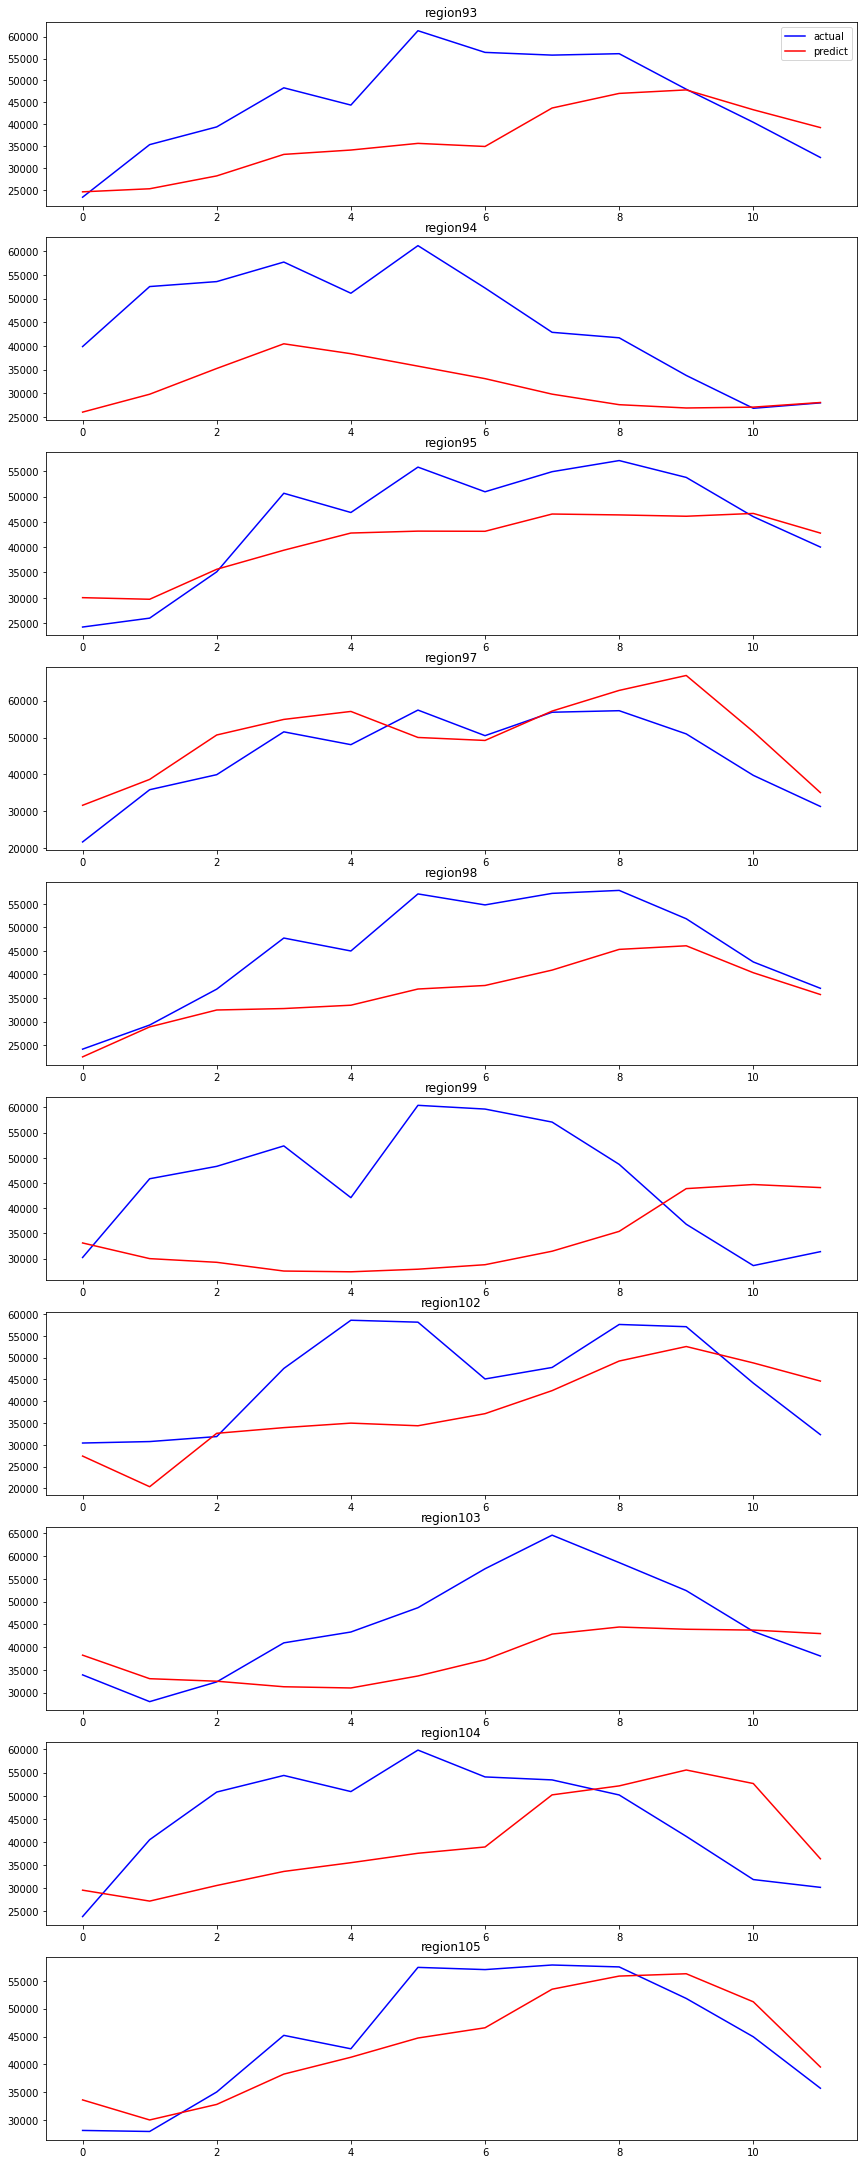

In [ ]:
fig, axs = plt.subplots(len(df[1]),figsize=(12,30))
fig.tight_layout()
def plot_predict(x_test,y_test,model,axe,region):
  y_predict=model.predict(x_test)
  y_final_predict=sc_y.inverse_transform(y_predict)
  y_final_predict=pd.DataFrame(y_final_predict)
  y_test_df=pd.DataFrame(sc_y.inverse_transform(y_test))
  axe.plot(y_test_df,label='actual',color='blue')
  axe.plot(y_final_predict,label='predict',color='red')
  axe.set_title('region'+str(region))
  #plt.subplots_adjust(hspace = 10)

#plot_predict(x_train[-12:],y_train[-12:])
for g_i in range(len(df[1])): 
  plot_predict(x_test_region_sep[g_i],y_test_region_sep[g_i],model_region_sep[g_i],axs[g_i],keys[g_i])
axs[0].legend()

draft part

In [ ]:
#input processing, transfer dataframe to torch
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
sc_y=StandardScaler()
for g_i in range(len(df[1])):
  data_train_list_x[g_i]=torch.from_numpy(sc.fit_transform(data_train_list_x[g_i])).float()
  data_train_list_y[g_i]=torch.from_numpy(sc_y.fit_transform(np.reshape(data_train_list_y[g_i].to_numpy(),(-1,1)))).float()
  data_test_list_x[g_i]=torch.from_numpy(data_test_list_x[g_i].to_numpy()).float()
  data_test_list_y[g_i]=torch.from_numpy(data_test_list_y[g_i].to_numpy()).float()
  print(g_i,data_train_list_x[g_i].size(),data_train_list_y[g_i].size(),data_test_list_x[g_i].size(),data_test_list_y[g_i].size())
# hops=6
# num_records=data_train_list_x[g_i].size(0)
# num_cols=data_train_list_x[g_i].size(1)
# x_train=[]
# y_train=[]
# for h in range(hops,num_records):
#   x_train.append(data_train_list_x[0][h-hops:h,:])
#   y_train.append(data_train_list_y[0][h,0])
# x_train=torch.tensor([x_train])
# y_train=torch.tensor([y_train])
# print(x_train.size())

0 torch.Size([60, 4]) torch.Size([60, 1]) torch.Size([12, 4]) torch.Size([12])
1 torch.Size([60, 4]) torch.Size([60, 1]) torch.Size([12, 4]) torch.Size([12])
2 torch.Size([60, 4]) torch.Size([60, 1]) torch.Size([12, 4]) torch.Size([12])
3 torch.Size([60, 4]) torch.Size([60, 1]) torch.Size([12, 4]) torch.Size([12])
4 torch.Size([60, 4]) torch.Size([60, 1]) torch.Size([12, 4]) torch.Size([12])
5 torch.Size([60, 4]) torch.Size([60, 1]) torch.Size([12, 4]) torch.Size([12])
6 torch.Size([60, 4]) torch.Size([60, 1]) torch.Size([12, 4]) torch.Size([12])
7 torch.Size([60, 4]) torch.Size([60, 1]) torch.Size([12, 4]) torch.Size([12])
8 torch.Size([60, 4]) torch.Size([60, 1]) torch.Size([12, 4]) torch.Size([12])
9 torch.Size([60, 4]) torch.Size([60, 1]) torch.Size([12, 4]) torch.Size([12])


In [ ]:
def training_loop(n_epochs, model, optimiser, loss_fn, 
                  train_input, train_target, test_input, test_target):
    for i in range(n_epochs):
        def closure():
            optimiser.zero_grad()
            print('start model')
            out = model(train_input)
            #print(out.size(),train_target.size())
            loss = loss_fn(out, train_target)
            loss.backward()
            return loss
        optimiser.step(closure)
        #print('stage 2')
        with torch.no_grad():
            future = 6
            pred = model(test_input, future_preds=future)
            # use all pred samples, but only go to 999
            loss = loss_fn(pred[:, :-future], test_target)
            y = pred.detach().numpy()
        # draw figures
        plt.figure(figsize=(12,6))
        plt.title(f"Step {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1] # 999
        def draw(yi, colour):
            plt.plot(np.arange(n), yi[:n], colour, linewidth=2.0)
            plt.plot(np.arange(n, n+future), yi[n:], colour+":", linewidth=2.0)
        draw(y[0], 'r')
        draw(y[1], 'b')
        draw(y[2], 'g')
        plt.savefig("predict%d.png"%i, dpi=200)
        plt.close()
        # print the loss
        out = model(train_input)
        loss_print = loss_fn(out, train_target)
        print("Step: {}, Loss: {}".format(i, loss_print))

In [ ]:

from model import LSTM
model= LSTM()
criterion = nn.MSELoss()
optimiser = optim.LBFGS(model.parameters(), lr=0.08)
training_loop(n_epochs = 10,
              model = model,
              optimiser = optimiser,
              loss_fn = criterion,
              #L = 72,
              train_input = data_train_list_x[0],
              train_target = data_train_list_y[0],
              test_input = data_test_list_x[0],
              test_target = data_test_list_y[0])

start model


AttributeError: ignored

# **VAR**

In [ ]:
var = VAR(data_train_list[0])
maxlags = 1
x= var.select_order(10)
x.summary()
model_fit = var.fit()
print(data_test_list[0])
yhat = model_fit.forecast(data_test_list[0], steps=1)

In [ ]:
results = var.fit(10)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 06, Apr, 2022
Time:                     01:25:48
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -187.825
Nobs:                     50.0000    HQIC:                  -193.863
Log likelihood:           4839.67    FPE:               -6.10273e-81
AIC:                     -197.576    Det(Omega_mle):    -1.81454e-82
--------------------------------------------------------------------
Results for equation precip
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.221592         0.020993           10.556           0.000
L1.precip         -1.752298         0.000409        -4280.948           0.000
L1.smos            0.147326         0.000236          625.004          

3
[0 1 2 3 4 5 6 7 8 9]
10


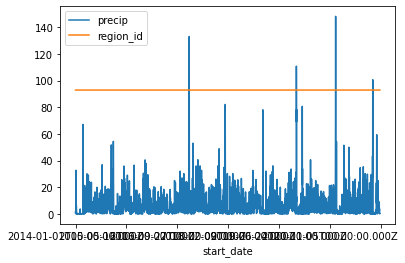

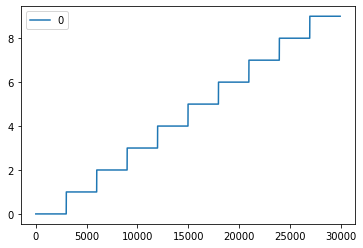

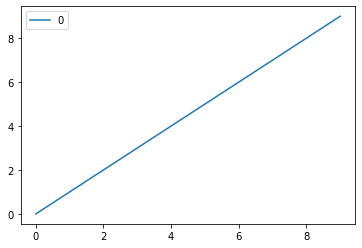

In [ ]:
df=Precipitation_series.groupby('region_id').grouper.group_info
r1=Precipitation_series.groupby('region_id').get_group(93)
r1.plot()
print(len(df))
pd.DataFrame(df[0]).plot()
print(df[1])
pd.DataFrame(df[1]).plot()
print(df[2])
#pd.DataFrame(df[2]).plot()
#for i in range(len(df)):
  #pd.DataFrame(Precipitation_series.groupby('region_id').grouper.group_info[1])